# 04-02 - Likelihood of the Stochastic Block Model

*May 17 2023*  

Taking a statistical inference perspective on the stochastic block model, we calculate the likelihood of model parameters for a given empirical network. We use this function to compare the likelihood of different community structures in an empirical network.

In [1]:
import pathpy as pp
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm_notebook as tqdm

plt.style.use('default')
sns.set_style("whitegrid")

    
from numpy import linalg as npl
import scipy as sp

import scipy.special
from decimal import *
import string
from collections import Counter

We implement a `python` function which - based on an empirical network $G_e$, a fixed number of blocks $B$, and a given block assignment vector $\vec{z}$ - computes the maximum likelihood estimate over all stochastic block matrices $\mathbf{M}$. For this purpose, we use the maximum likelihood function introduced in the lecture.

In [2]:
def log(x):
    if x == 0:
        return 0
    else:
        return np.log(x)

In [3]:
def SBM_likelihood(M, z, n: pp.Network):
    B = len(set(z))

    # C[k] counts number of nodes in block k
    C = Counter(z)

    L = 0
    
    # E[k,l] counts how many links exist between nodes in block k and block l
    E = np.zeros((B,B))

    # N[k,l] counts how many links can possibly exist between nodes in block k and l
    N = np.zeros((B,B))
    for k in range(B):
        for l in range(B):
            # calculate possible links
            if k == l:
                N[k,l] = scipy.special.binom(C[k], 2)
            else:
                N[k,l]= C[k] * C[l]
            for e in n.edges:
                if (z[n.nodes.index[e.v.uid]] == k and z[n.nodes.index[e.w.uid]] == l) or (z[n.nodes.index[e.v.uid]] == l and z[n.nodes.index[e.w.uid]] == k):
                    E[k,l] += 1                 

    for k in range(B):
        for l in range(k+1):
            L += E[k,l] * log(M[k,l]) + (N[k,l]-E[k,l]) * log(1-M[k,l])
    if L<0:
        return np.exp(L)
    else:
        return L

We consider the example network from the lecture:

In [4]:
n = pp.Network(directed=False)
n.add_edge('a', 'b')
n.add_edge('b', 'c')
n.add_edge('a', 'c')
n.add_edge('b', 'd')
n.add_edge('d', 'f')
n.add_edge('d', 'e')
n.add_edge('e', 'f')
n.plot(edge_color='gray')

We test our likelihood function in the example network. For this, we specify a block assignment vector and a stochastic block matrix. We color the nodes and calculate the likelihood of model parameters given the observed network. 

If we consider parameters that do not allow for edges between blocks, the likelihood is zero.

In [5]:
z = np.array([0,1,0,0,1,1])
M = np.matrix('1 0; 0 1')

colors = sns.color_palette("Set1", 10)
for v in n.nodes:
    v['color'] = colors[z[n.nodes.index[v.uid]]]
n.plot(edge_color='gray')

SBM_likelihood(M, z, n)

0.0

The likelihood of parameters that allow edges between communities is larger than zero. Since the model is unlikely to generate the observed network based on the specified parameters, the likelihood is very small.

In [6]:
z = np.array([0,1,0,0,1,1])
M = np.matrix([[1/3, 5/9],[5/9, 1/3]])

colors = sns.color_palette("Set1", 10)
for v in n.nodes:
    v['color'] = colors[z[n.nodes.index[v.uid]]]
n.plot(edge_color='gray')

SBM_likelihood(M, z, n)

4.5321038866843536e-05

The likelihood of this block assignment vector and stochastic block matrix are small because they do not match the natural community structure of the network. We can increase the likelihood of our model if we use parameters where the block assignment vector matches the natural community structure.

In [7]:
z = np.array([0,0,0,1,1,1])
M = np.matrix([[1, 1/9],[1/9, 1]])
colors = sns.color_palette("Set1", 10)

for v in n.nodes:
    v['color'] = colors[z[n.nodes.index[v.uid]]]
n.plot(edge_color='gray')

SBM_likelihood(M, z, n)

0.04330492701432728

## Maximum likelihood estimation

We now combine the likelihood function with the estimation of block matrix entries that we already considered in the previous notebook (and which we formally established as maximum likelihood estimate in the lecture). For a given empirical network, this allows us to calculate the maximum likelihood of a block assignment vector over all possible stochastic block matrices, i.e. different from the function above we do not need to specify the matrix $M$, since we internally use the maximum likelihood estimate given $\vec{z}$.

In [8]:
def SBM_max_likelihood(z, n: pp.Network):
    B = len(set(z))

    # C[k] counts number of nodes in block k
    C = Counter(z)

    L = 0
    
    # E[k,l] counts how many links exist between nodes in block k and block l
    E = np.zeros((B,B))

    # N[k,l] counts how many links can possibly exist between nodes in block k and l
    N = np.zeros((B,B))
    
    for k in range(B):
        for l in range(B):
            # calculate possible links
            if k == l:
                N[k,l] = scipy.special.binom(C[k], 2)
            else:
                N[k,l]= C[k] * C[l]
            for e in n.edges:
                if (z[n.nodes.index[e.v.uid]] == k and z[n.nodes.index[e.w.uid]] == l) or (z[n.nodes.index[e.v.uid]] == l and z[n.nodes.index[e.w.uid]] == k):
                    E[k,l] += 1                 
    M = E / N
    for k in range(B):
        for l in range(k+1):
            L+= E[k,l] * log(M[k,l]) + (N[k,l] - E[k,l]) * log(1-M[k,l])
    if L<0:
        return np.exp(L), M
    else:
        return L, M

With this function, the detection of a fixed number of communities $B$ can be turned into an optimization problem. For a given network, we simply need to find the block assignment vector z with maximal likelihood.

In [9]:
z = [0,1,0,0,1,1]
L, M = SBM_max_likelihood(z, n)
print(L)
print(M)

4.5321038866843536e-05
[[0.33333333 0.55555556]
 [0.55555556 0.33333333]]


In [10]:
z = [0,0,0,1,1,1]
L, M = SBM_max_likelihood(z, n)
print(L)
print(M)

0.04330492701432728
[[1.         0.11111111]
 [0.11111111 1.        ]]


Due to the small size of the example network, we can use the naive approach of enumerating all possible block assignment vectors $\vec{z}$. We plot the likelihood for each assignment vector $\vec{z}$ as shown in the lecture.

In [11]:
nodes = 6

# Iterate through all block assignments and infer communities
likelihoods = []
for i in tqdm(range(1,(2**nodes)-1)):
    z = [0]*nodes
    j = 0
    for x in "{0:b}".format(i).zfill(nodes):
        z[j] = int(x)
        j = j+1
    L, x = SBM_max_likelihood(z, n)
    if not np.isnan(L):
        likelihoods.append(L)
    else:
        likelihoods.append(0)

/tmp/ipykernel_18749/2874127381.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(1,(2**nodes)-1)):


  0%|          | 0/62 [00:00<?, ?it/s]

/tmp/ipykernel_18749/725269256.py:25: RuntimeWarning: invalid value encountered in divide
  M = E / N


<Figure size 640x480 with 0 Axes>

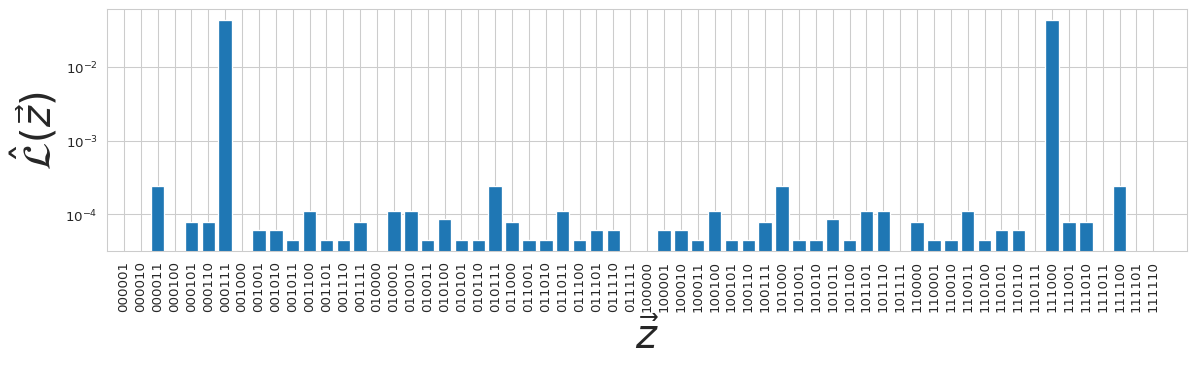

Max. Likelihood block asssignment (a,b,c,d,e,f) = 000111


In [12]:
# Plot likelihoods for all possible block assignments
plt.clf()
plt.figure(figsize=(15,4), dpi=96)
plt.bar(range(1,(2**nodes)-1), likelihoods, align='center')
plt.yscale('log')
plt.xlim([0,2**nodes])
x_ticks = ["{0:b}".format(i).zfill(nodes) for i in range(1,(2**nodes)-1)]
plt.xticks(range(1,2**nodes-1), x_ticks)
plt.ylabel(r'$\hat{\mathcal{L}}(\vec{z})$', fontsize=30)
plt.xlabel(r'$\vec{z}$', fontsize=30)
plt.xticks(rotation=90)
plt.subplots_adjust(bottom=0.25)
plt.subplots_adjust(left=0.15)
plt.show()

# Find z that maximises likelihood 
z_max = np.argmax(likelihoods)
z_max_vec = "{0:b}".format(1+z_max).zfill(nodes)
print("Max. Likelihood block asssignment (a,b,c,d,e,f) =", z_max_vec)